<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Uniform time sampling with Pyleoclim

## Preamble

A common issue in the paleosciences is the presence of uneven time spacing between consecutive observations. While `pyleoclim` includes several methods that can deal with this effectively, there are certain applications for which it is ncessary to place the records on a uniform time axis. In this tutorial you'll learn a few ways to do with `pyleoclim`.

### Goals:

* Become familiar with interpolation, binning, and Gaussian kernel coarsening in Pyleoclim

**Reading Time:**

10 minutes

### Keywords

Signal Processing; Visualization

### Pre-requisites

None. This tutorial assumes basic knowledge of Python. If you are not familiar with this coding language, check out this tutorial: http://linked.earth/ec_workshops_py/.

### Relevant Packages

Matplotlib

## Data Description
EPICA Dome C Deuterium record from [Jouzel et al, 2007](https://doi.org/10.1126/science.1141038)

## Demonstration

Let's import the packages needed for this tutorial:

In [5]:
%load_ext autoreload
%autoreload 2
import pyleoclim as pyleo
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The dataset ships with Pyleoclim, so it is very quick to load. However, the original timescale is in years BP, which gets unwieldy after counting throigh 800,000 of them. We thus convert to "ky BP", using intuitive semantics:

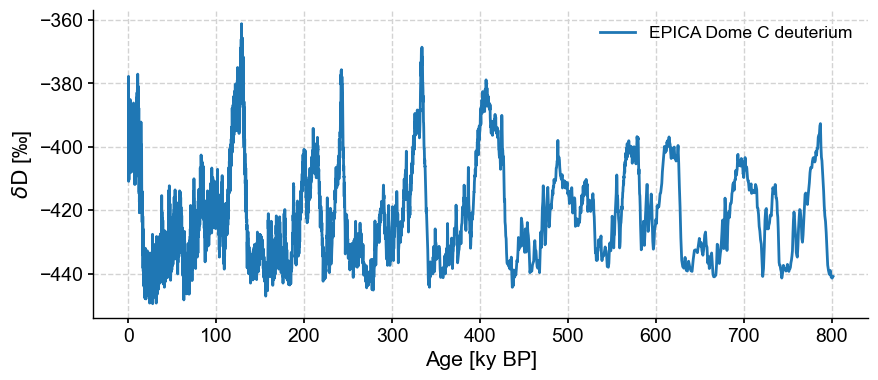

In [2]:
tsy = pyleo.utils.load_dataset('EDC-dD')
ts = tsy.convert_time_unit('ky BP')
fig, ax = ts.plot() 

## An uneven resolution
First we inspect the records' resolution, i.e. the distribution and sequence of its time increments.
TODO: replace with `resolution.dashboard()`

Text(0.5, 0.98, 'Resolution properties of EPICA Dome C deuterium')

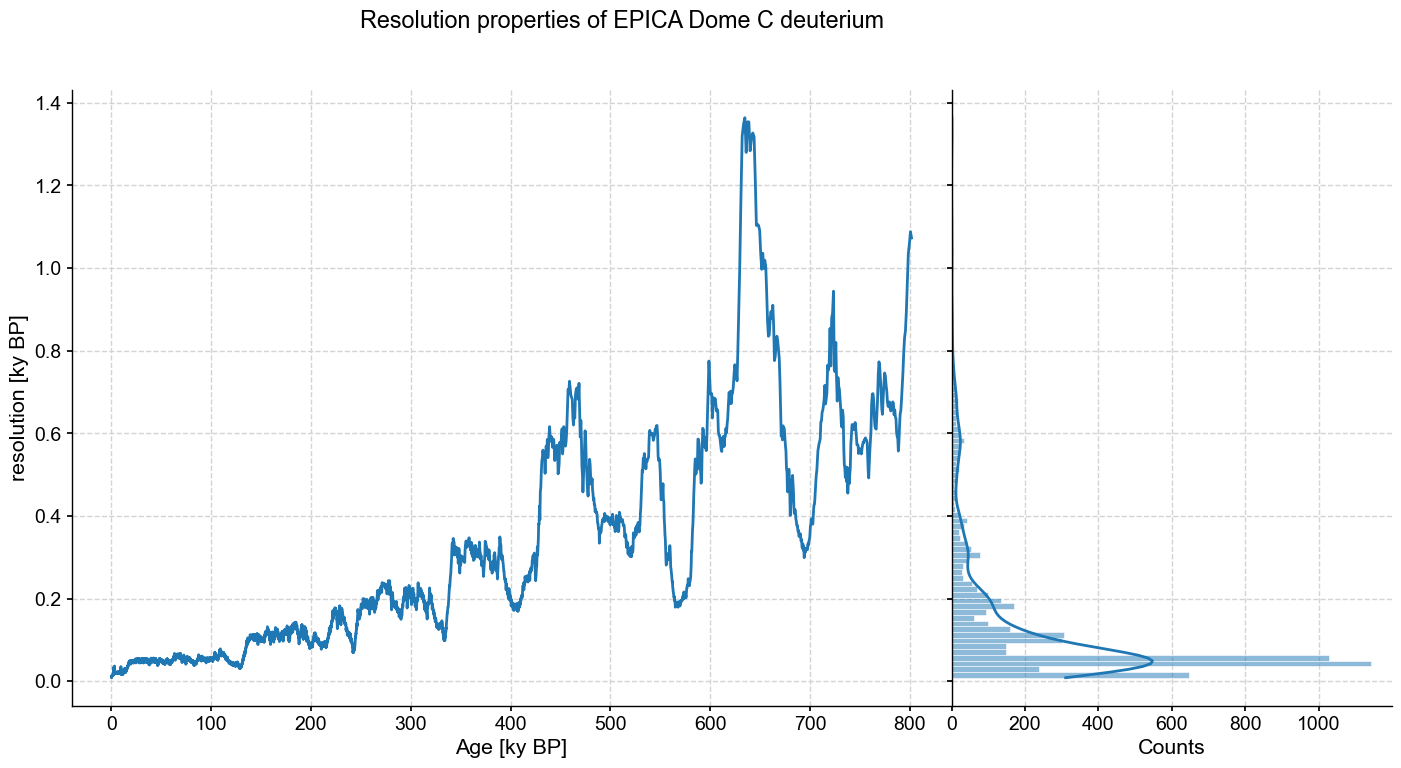

In [17]:
from matplotlib import gridspec
gs = gridspec.GridSpec(1, 3, wspace=0)
gs.update(left=0, right=1.2)
ax = {}
res = ts.resolution()
fig = plt.figure(figsize=[11, 8])
ax['res'] = fig.add_subplot(gs[0, :-1])
res.plot(ax=ax['res'])
ax['res_hist'] = fig.add_subplot(gs[0, -1:])
res.histplot(ax=ax['res_hist'],ylabel='Counts',vertical=True)
ax['res_hist'].set_yticklabels([])
ax['res_hist'].set_ylabel('')
fig.suptitle(f'Resolution properties of {ts.label}')

We can see that the series is very unevenly spaced, with resolution of ~100y at the beginning (top), increasing to over 1000y near the end (bottom) of the core.  There a number of different reasons we might want to place these data on an even time grid. One is that  we want to apply a technique that requires it to be evenly spaced (most timeseries methods make this assumption). For instance, a [savitzky-golay filter](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.filter)), a detrending method, and so on. First we should check whether this is necessary with the `.is_evenly_spaced()` method (this may already seem reasonably clear, but it never hurts to check):

In [18]:
ts.is_evenly_spaced()

False

The data are not evenly spaced, as we suspected. Now there are a few different methods available in `Pyleoclim` to place them on a uniform axis: interpolating, binning, resampling and coarse graining via a Gaussian kernel. Let's look at them in sequence. 

### Solution 1: Interpolation

Interpolation projects the data onto an evenly spaced time axis with a distance between points (step size) of our choosing. The default step size is the mean spacing between consecutive points. There are a variety of different methods by which the data can be interpolated, these being: `linear`, `nearest`, `zero`, `slinear`, `quadratic`, `cubic`, `previous`, and `next`. More on these and their associated key word arguments can be found in the [documentation](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.interp). By default, `.interp()` implements linear interpolation:

In [19]:
ts_linear = ts.interp() #default method = 'linear'

In [20]:
#Checking whether or not the series is now evenly spaced
ts_linear.is_evenly_spaced()

True

Success! Let's take a look at our handiwork.

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

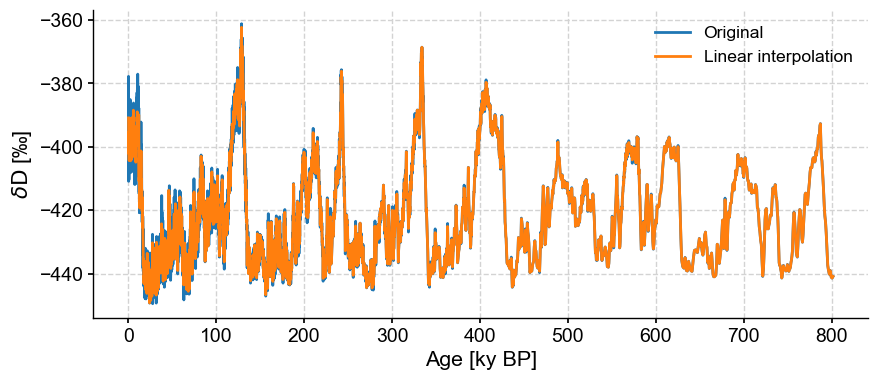

In [21]:
fig, ax = ts.plot(label='Original')
ts_linear.plot(ax=ax,label='Linear interpolation')

If we wanted a coarser resolution, we need only specify the `step` parameter.

In [29]:
ts_linear = ts.interp(step=5) 
ts_linear.label = '5ka linear interpolation'

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

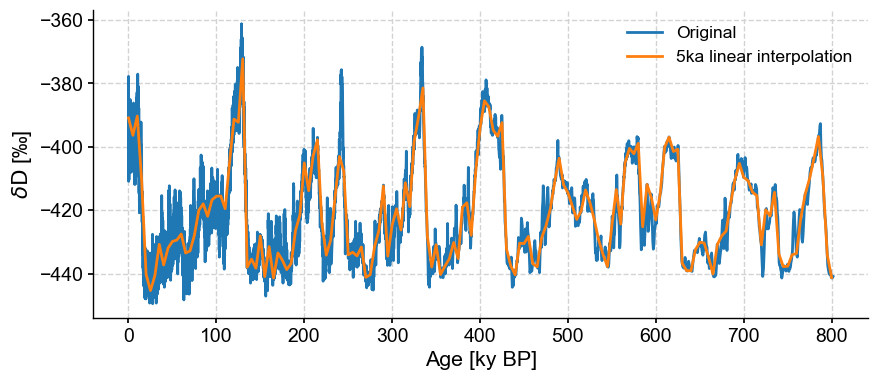

In [30]:
fig, ax = ts.plot(label='Original')
ts_linear.plot(ax=ax)

Linear interpolation is generally safest, because it makes the fewest assumptions. However, for coarse time grids, it can look a little jagged. 

Let's compare a few of the different methods with one another just to see how they might differ:

In [37]:
ts_quadratic=ts.interp(method='quadratic',step=5)
ts_next = ts.interp(method='next',step=5)
ts_zero = ts.interp(method='zero',step=5)

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

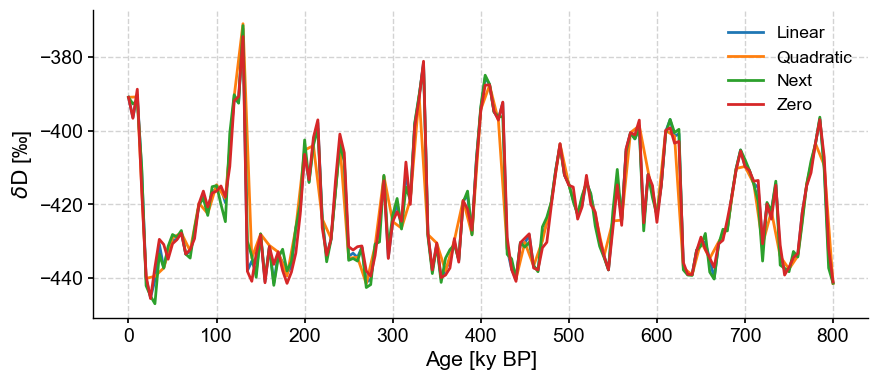

In [34]:
fig,ax = ts_linear.plot(label='Linear')
ts_quadratic.plot(ax=ax,label='Quadratic')
ts_next.plot(ax=ax,label='Next')
ts_zero.plot(ax=ax,label='Zero')

You can see how the methods can produce fairly similar results. If we fiddled more with key word arguments the differences would be even more obvious. Play around a bit and read the documentation to find the best solution for you.

### Solution 2: Binning

Instead of interpolating we could average the series values over uniform bins. The defaults for binning are inherently quite conservative, picking as bin size the coarsest time spacing present in the dataset, and averaging data over a uniform sequence of such intervals: 

In [39]:
ts_bin = ts.bin()
ts_bin.label = 'binning (default)'

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

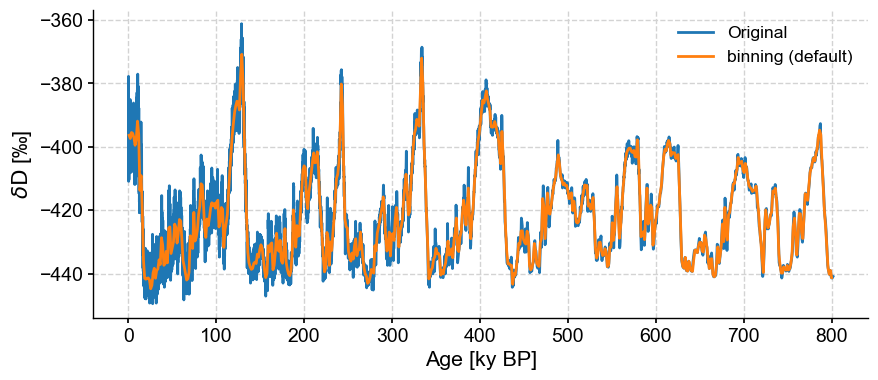

In [40]:
fig,ax = ts.plot(label='Original')
ts_bin.plot(ax=ax)

JEG: this doesn't look conservative at all to me. Are we use it's not using the mean bin size?

If we want this to be less conservative we can set the bin size using the `bin_size` key word argument, but that means the series is no longer guaranteed to be evenly spaced.

In [43]:
ts_bin = ts.bin(bin_size=5)

/var/folders/bf/_x19bm694857h_hrw44j0p7w0000gn/T/ipykernel_35067/1042173271.py:1: UserWarning: The step, time axis, or bin edges have been set, the series may not be evenly_spaced
  ts_bin = ts.bin(bin_size=5)


<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

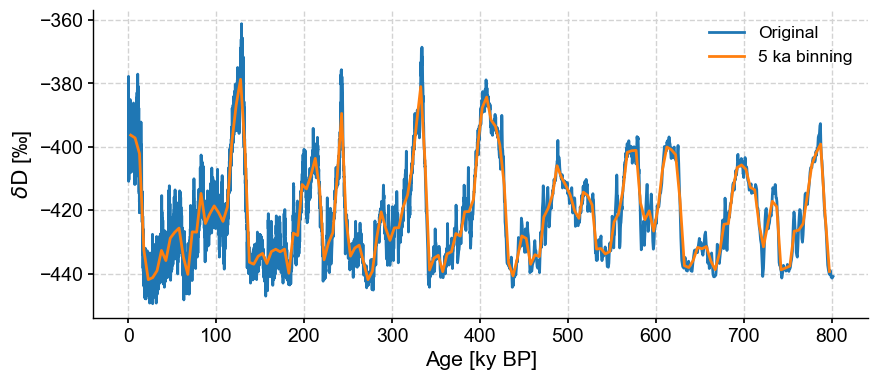

In [44]:
fig,ax = ts.plot(label='Original')
ts_bin.plot(ax=ax,label='5 ka binning')

### Solution 3: Resampling

As introduced in [the pandas demo](./L0_paleopandas.md), another option is to use the pandas [resampler](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.resample), then aggregate the data in some way, e.g. by averaging (though resample offers [many more options](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling), few of which are helpful to a paleoclimatologist). Let's stick with goold old averaging, then:


<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

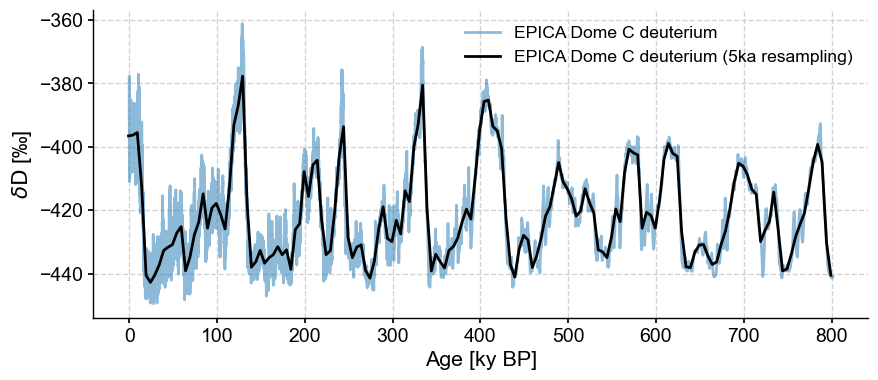

In [56]:
ts5k = ts.resample('5ka').mean()
fig, ax = ts.plot(alpha=.5)
ts5k.plot(ax=ax,color='black')

One nice thing is that `resample` automatically updates the `Series` label for you. It also understand time semantics, so you can specify units, as we've done here. If you think it looks very much like binning, you are not wrong. Let's line them up to better see the effect:

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

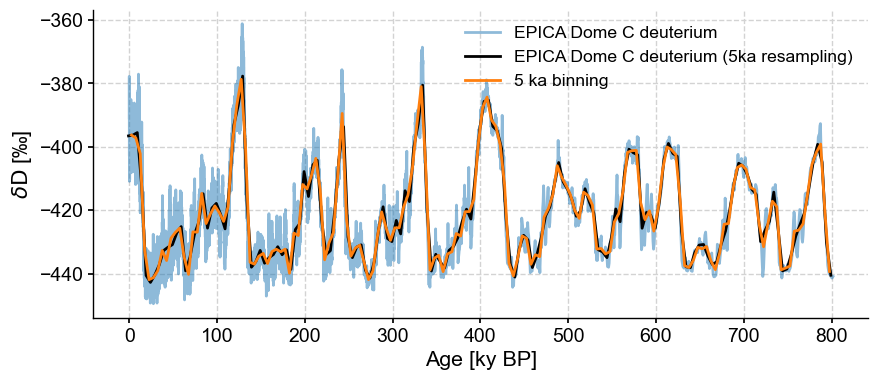

In [55]:
fig, ax = ts.plot(alpha=.5)
ts5k.plot(ax=ax,color='black')
ts_bin.plot(ax=ax,label='5 ka binning')

Indeed, they are very close.  

### Solution 4: Coarsening with a Gaussian kernel

The last option is to coarsen the series using a Gaussian kernel ([Rehfeld et al. (2011)](https://doi.org/10.5194/npg-18-389-2011)) via the `.gkernel()` method. Like `.bin()` this technique is conservative and uses the max space between points as the default spacing. Unlike `.bin()`, `.gkernel()` uses a Gaussian kernel to calculate the weighted average of the time series over these intervals.

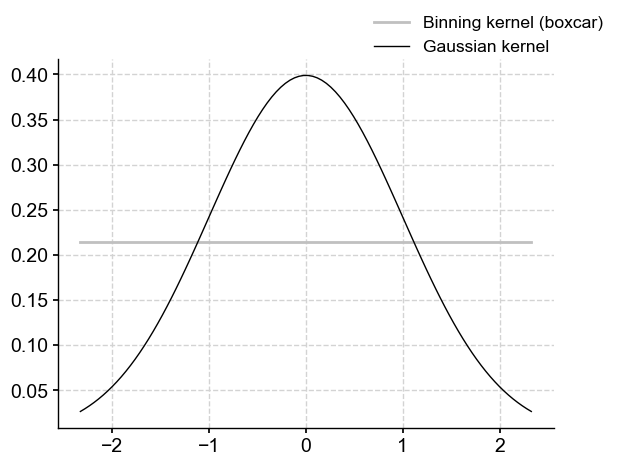

In [62]:
from scipy.stats import norm
import numpy as np
rv = norm()
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
unif = np.ones_like(x)/np.ptp(x)
fig, ax = plt.subplots()
ax.plot(x, unif, color='silver',label='Binning kernel (boxcar)')
ax.plot(x, rv.pdf(x), 'k-', lw=1, label='Gaussian kernel')
fig.legend()

In [20]:
ts_gk = ts.gkernel()

/Users/alexanderjames/Documents/GitHub/Pyleoclim_util_main/pyleoclim/utils/tsutils.py:263: RuntimeWarning: invalid value encountered in double_scalars
  yc[i]  = sum(weight*yslice)/sum(weight)


<AxesSubplot:xlabel='Age [yr BP]', ylabel='δ18osw [per mil]'>

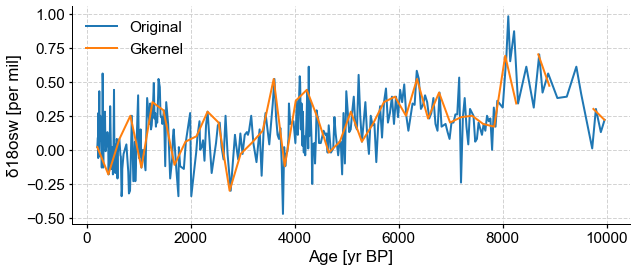

In [46]:
fig,ax = ts.plot(label='Original')
ts_gk.plot(ax=ax,label='Gkernel')

You may want to play with key word arguments `step_style` and the kernel bandwidth `h` a bit.

Each of these methods has its own key word arguments that can be adjusted to produce different results. The investigation of these arguments and how they effect the outcome of the imputation is left as an exercise for the reader.